# Green's function

This notebook computes the (retarded) real-time Green's function $G(t)$ for the sparse SYK model using the [dynamite](https://dynamite.readthedocs.io/en/latest/) library. The procedure to evaluate the Greens's function is the same as outlined in [[arxiv:2002.05725]](https://arxiv.org/abs/2002.05725).

Although dynamite runs well in jupyter notebooks, it will run only on a single process. Running in parallel under MPI requires a slight adaptation of the code below, but the calls to dynamite functions remain unchanged. The implementations of the sparse Hamiltonian and the regular hypergraph can be found in `Hamiltonian.py`  and `Hypergraph.py`.

In [1]:
import numpy as np
from dynamite import config
from dynamite.states import State
from dynamite.extras import majorana
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import sys
sys.path.append('..')
from Hamiltonian import hamiltonian_sparse, print_tex
from Hypergraph import regular_hypergraph

### Set test parameters

In [2]:
N = 20
q = 4
k = 2
beta = 10
config.L = N//2

tmax = 20
n_points = 20
t_values = np.linspace(0, tmax, n_points)

test_seed = 0

### Sparse Hamiltonian example

In [3]:
hyperedges = regular_hypergraph(N, k, q, test_seed)
H_sparse = hamiltonian_sparse(N, k, q, hyperedges, test_seed)

print(f'Hyperedges: \n{hyperedges}')
print('Hamiltonian:')
print_tex(H_sparse)

Hyperedges: 
((1, 8, 12, 13), (7, 11, 15, 19), (3, 4, 9, 17), (5, 8, 10, 18), (2, 3, 11, 16), (3, 11, 13, 15), (7, 16, 18, 19), (0, 2, 3, 9), (0, 13, 15, 19), (1, 4, 17, 18), (3, 9, 11, 16), (2, 6, 12, 15), (5, 12, 13, 18), (1, 6, 10, 13), (7, 9, 14, 19), (4, 5, 7, 14), (0, 4, 5, 16), (1, 7, 12, 18), (2, 3, 4, 19), (0, 2, 11, 16), (9, 11, 14, 15), (2, 4, 10, 16), (0, 7, 8, 11), (5, 8, 10, 14), (2, 6, 13, 17), (1, 3, 17, 18), (0, 6, 15, 18), (0, 1, 4, 16), (6, 14, 15, 17), (4, 5, 10, 11), (6, 7, 8, 14), (1, 2, 9, 19), (5, 6, 12, 17), (3, 8, 9, 14), (1, 13, 14, 17), (7, 9, 10, 12), (8, 10, 15, 16), (0, 6, 18, 19), (5, 10, 12, 13), (8, 12, 17, 19))
Hamiltonian:


<IPython.core.display.Math object>

### Evaluate Green's function

The (retarded) Green's function is defined as 

$$G(t) = 2\text{Re}\langle\chi_j(t)\chi_j(0)\rangle_\beta$$
 
In principle, we need to compute the thermal average $\langle\ldots\rangle_\beta = \frac{1}{Z}\text{Tr}[\ldots e^{-\beta H}]$ denotes the thermal average at inverse temperature $\beta$ with partition function $Z=\text{Tr}[e^{-\beta H}]$. Instead, we can obtain a good approximation of the Green's function by evaluating the expectation value on a random state. More precisely, we create a random state $|\psi\rangle$ and we perform imaginary time evolution to obtain

$$|\beta\rangle = e^{-\frac{\beta}{2}H}|\psi\rangle$$

Then,
$$\langle\chi_j(t)\chi_j(0)\rangle_\beta \approx \frac{\langle\beta|\chi_j(t)\chi_j(0)|\beta\rangle}{\langle\beta|\beta\rangle} = \frac{\langle \beta| e^{iHt}\chi_j e^{-iHt}\chi_j|\beta\rangle}{\langle\beta|\beta\rangle}$$

In [4]:
def green_retarded(N, k, q, beta, hyperedges, t_values, random_seed):
    '''
    Input: N - Number of Majorana fermions
           k - Sparsity parameter
           q - Sets a q-body interaction
           hyperedges - List of hyperedges
           t_values - Array with values of t 
           random_seed - Seed for sampling couplings
    
    Return: Numpy array of len(t_values) with the values of the G(t)
    '''
    
    # Build Hamiltonian
    H = hamiltonian_sparse(N, k, q, hyperedges, random_seed)
    
    # Get time step
    tmax = t_values[-1]
    n_points = len(t_values)
    dt = tmax/n_points
    
    # Pick a single Majorana chi_1
    maj = majorana(1).scale(1/np.sqrt(2))
    
    # Create normalized beta state from random state
    beta_state = State(state='random', seed=random_seed)
    H.evolve(beta_state, t=-1j*beta/2, result=beta_state)
    beta_state.normalize()

    # Define two states to be evolved with the Hamiltonian
    state1 = maj*beta_state
    state2 = beta_state

    # Perform real time evolution in small steps dt
    G_list = []
    for _ in range(len(t_values)):
        corr = (2*maj*state1).dot(state2).real
        G_list.append(corr) 
        H.evolve(state1, t=dt, result=state1)
        H.evolve(state2, t=dt, result=state2)

    return np.array(G_list)

In [5]:
# Test Green's function
green_retarded(N, k, q, beta, hyperedges, t_values, test_seed)

array([1.        , 0.93869987, 0.81031871, 0.70729232, 0.65844514,
       0.63991689, 0.63155904, 0.62532698, 0.61433531, 0.59691321,
       0.57573881, 0.55096283, 0.52330031, 0.49766138, 0.4770351 ,
       0.45791264, 0.4367092 , 0.41709734, 0.40398364, 0.39309597])

### Evaluate average over different realizations of the random couplings

In [6]:
%%time
G = np.array([green_retarded(N, k, q, beta, hyperedges, t_values, s) for s in range(50)])
G_average = np.mean(G, axis=0)

CPU times: user 30.4 s, sys: 12.2 ms, total: 30.4 s
Wall time: 30.5 s


In Jupyter notebooks, dynamite runs on a single process, but we can still paralellize the calculation over different choices of the random couplings (i.e., different values of the seed that generate $J_{j_1,..., j_q}$) using the python `multiprocessing` library.

In [7]:
%%time
from multiprocessing import Pool

# Parallelize using starmap
args = [(N, k, q, beta, hyperedges, t_values, s) for s in range(50)]

with Pool() as pool:
    G = pool.starmap(green_retarded, args)
    
G_average2 = np.mean(G, axis=0)

CPU times: user 65.9 ms, sys: 35.7 ms, total: 102 ms
Wall time: 15.5 s


### Plot results

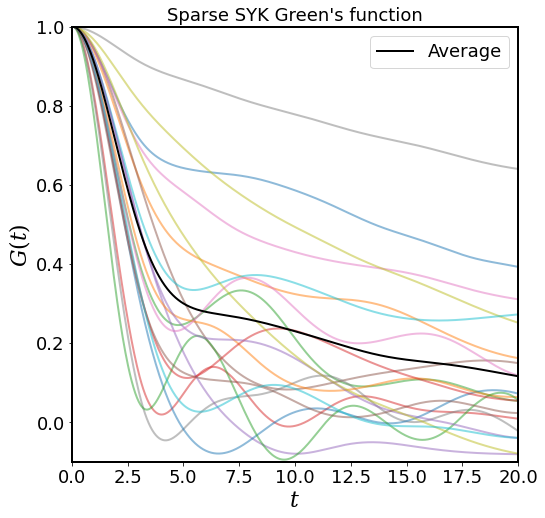

In [8]:
# Plotting settings
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.linewidth'] = 2.0
plt.rc('font', size=18)          
plt.rc('axes', titlesize=18)     
plt.rc('axes', labelsize=22)   
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)   
plt.rc('legend', fontsize=18)  
plt.rc('figure', titlesize=24) 
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Plot 20 realizations
for g in G[:20]:
    interpolation = interp1d(t_values, g, kind='cubic')
    X = np.linspace(t_values.min(), t_values.max(), 500)
    Y = interpolation(X)
    plt.plot(X, Y, '-', alpha=0.5)

# Plot average
interpolation = interp1d(t_values, G_average, kind = "cubic")
X = np.linspace(t_values.min(), t_values.max(), 500)
Y = interpolation(X)
plt.plot(X, Y, color='k', label='Average')

plt.title(r"Sparse SYK Green's function")
plt.xlabel(r'$t$')
plt.ylabel(r'$G(t)$')
plt.xlim([0, tmax])
plt.ylim([-0.1, 1])
plt.legend(loc='upper right')
plt.show()